In [1]:
from fastspt import simulate, fit2, tracklen
import numpy as np

%matplotlib inline

%load_ext autoreload

%autoreload 2

# 1. Simulation tools

`simulate` module implements 2-state model simulations

## Single track

In [2]:
track = simulate.track()
track

      x [um]    y [um]  t [sec]  frame []  sigma [um]  free []  id []
0   0.051700 -0.054334     0.00       0.0    0.021338      1.0    0.0
1   0.024269 -0.087400     0.06       1.0    0.020048      1.0    0.0
2   0.037190 -0.119137     0.12       2.0    0.019340      1.0    0.0
3  -0.013457 -0.186149     0.18       3.0    0.014202      1.0    0.0
4  -0.057273 -0.197572     0.24       4.0    0.020139      1.0    0.0
5  -0.118228 -0.177657     0.30       5.0    0.013550      1.0    0.0
6  -0.173481 -0.186845     0.36       6.0    0.022998      1.0    0.0
7  -0.267666 -0.327666     0.42       7.0    0.018136      1.0    0.0
8  -0.255514 -0.321955     0.48       8.0    0.023608      1.0    0.0
9  -0.310574 -0.281128     0.54       9.0    0.022033      1.0    0.0
10 -0.332508 -0.281436     0.60      10.0    0.015689      1.0    0.0

In [3]:
track.xy

array([[ 0.05170049, -0.05433413],
       [ 0.02426938, -0.08740003],
       [ 0.03719039, -0.11913674],
       [-0.01345716, -0.18614852],
       [-0.0572728 , -0.19757235],
       [-0.11822836, -0.17765702],
       [-0.17348144, -0.18684545],
       [-0.26766579, -0.32766578],
       [-0.25551399, -0.32195511],
       [-0.31057436, -0.28112772],
       [-0.33250798, -0.28143598]])

In [4]:
track.sigma

array([[0.02133767],
       [0.02004785],
       [0.01933953],
       [0.01420226],
       [0.02013947],
       [0.01355009],
       [0.02299843],
       [0.01813562],
       [0.02360755],
       [0.02203302],
       [0.01568914]])

In [5]:
# Default parameters
simulate.track(track_id=0,
    start_time=0,
    dt=0.06,
    D_bound=0.02,
    D_free=0.06,
    loc_error=0.02,
    p_binding=0.0001,
    p_unbinding=0.001,
    p_bleaching=0.1,
    p_out_of_focus=0.01,
    min_len=5,
)

     x [um]    y [um]  t [sec]  frame []  sigma [um]  free []  id []
0  0.029612  0.034253     0.00       0.0    0.023651      0.0    0.0
1 -0.024166  0.029402     0.06       1.0    0.025281      0.0    0.0
2 -0.034625  0.039911     0.12       2.0    0.020181      0.0    0.0
3 -0.054085 -0.011455     0.18       3.0    0.023124      0.0    0.0
4 -0.046320  0.037512     0.24       4.0    0.024398      0.0    0.0
5 -0.068948  0.066295     0.30       5.0    0.020339      0.0    0.0
6 -0.010121  0.111705     0.36       6.0    0.020501      0.0    0.0

## List of tracks

In [10]:
p_bleaching=0.1
tracks = simulate.tracks(
    num_tracks=10000.0,
    dt=0.06,
    D_bound=0.0,
    D_free=0.05,
    loc_error=0.02,
    p_binding=0.0001,
    p_unbinding=0.001,
    p_bleaching=p_bleaching,
    p_out_of_focus=1e-05,
    min_len=2,
    use_tqdm=True,)

In [11]:
len(tracks)

10000

10000 tracks, 119607 localizations
Fit result: 1346.82 * e^(-x * 0.10) + -1.21


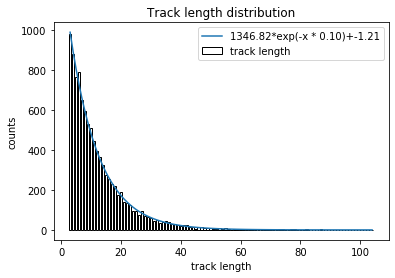

In [12]:
len_fit = tracklen.get_track_lengths_dist(tracks,)

In [15]:
np.testing.assert_almost_equal(len_fit, p_bleaching, decimal=1)

# 2. Fit kinetics

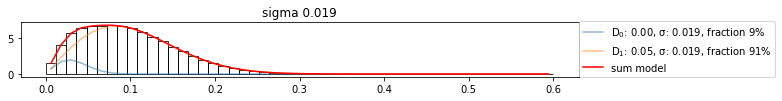

In [16]:
# fit one lag (1 Δt)
fit = fit2.fit_spoton_2_0(tracks)

In [17]:
fit

{'sigma': [0.01911923725058248],
 'D': [0.0, 0.050933183613147026],
 'F': [0.08850369255691676, 0.9114963074430833],
 'dt': 0.06,
 'n_tracks': 10000,
 'chi2': 0.018621211963316123,
 'chi2_norm': 0.00037242423926632246,
 'n_iter': 25,
 'path': None}

In [ ]:
# fit 5 lags (1..5 Δt)

fit = fit2.fit_spoton_2_0(tracks, n_lags=7, return_fit_result=1, D=(0.05, 0.5), n_bins=100, max_um=0.5)

In [19]:
fit['fit_result']

## simulate and fit 3 states

In [ ]:
tracks_3_states = simulate.tracks(D_free=0.04) + simulate.tracks(D_free=0.01)

In [ ]:
#first try 2-state fit
fit_2_states = fit2.fit_spoton_2_0(tracks_3_states, n_lags=5, n_bins=100)

In [ ]:
fit_2_states['chi2']

In [ ]:
# Try 3-states fit

fit_3_states = fit2.fit_spoton_2_0(
    tracks_3_states, 
    n_lags=5, 
    n_bins=100,
    D=(0,0.05,0.2),
    fit_D=(1,1,1,),
    F=(0.3,0.3,0.4),
    fit_F=(1,1,1)
)

In [ ]:
fit_3_states['chi2']

In [ ]:
# 4 states, maybe?? Why not!


fit_4_states = fit2.fit_spoton_2_0(
    tracks_3_states, 
    n_lags=5, 
    n_bins=100,
    D=(0,0.01,0.2,0.3),
    fit_D=(1,1,1,1),
    F=(0.3,0.3,0.2,0.2),
    fit_F=(1,1,1,1)
)

In [ ]:
fit_4_states

In [ ]:
fit_4_states['chi2']

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
all_fits = [fit_2_states, fit_3_states, fit_4_states]
chi2s = [f['chi2'] for f in all_fits]
n_states = [len(f['D']) for f in all_fits]
plt.plot(n_states, chi2s, 'o-')
plt.xlabel('number of states')
plt.ylabel('chi2')
plt.title('Fit of 3-states simulated data')


## Test the speed

In [ ]:
# 2 states with bound state
data = [simulate.tracks(num_tracks=1e3, D_bound=0.0, D_free=0.05, use_tqdm=False) for _ in fit2.tqdm(range(10))]

In [ ]:
fits = [fit2.fit_spoton_2_0(d, D=(0., .1),plot=False, n_lags=1, max_um=0.5, n_bins=50) for d in fit2.tqdm(data)]

In [ ]:
fit2.result_2_table(*fits)

In [ ]:
# 2 unbound states
print('simulate 10 datasets')
data = [simulate.tracks(num_tracks=4e3, D_bound=0.05, D_free=0.5, use_tqdm=False) for _ in fit2.tqdm(range(10))]

In [ ]:
# dibabling plot dramatically improves performance!
print('start fit')
fits = [fit2.fit_spoton_2_0(d, D=(0.2, 1),plot=False, n_lags=7, max_um=2, n_bins=50, return_fit_result=True) for d in fit2.tqdm(data)]

In [ ]:
table = fit2.result_2_table(*fits)
table.loc['mean'] = table.mean(0)
table.loc['std'] = table.std(0)
table

In [ ]:
# simulate unbound molecules
tracks = simulate.tracks(D_bound=0.05, D_free=0.5, num_tracks=4e3)

In [ ]:
fit2.fit_spoton_2_0(tracks, D=(0.1, 1), max_um=2, n_bins=100, n_lags=7)

In [ ]:
# fix sigma
fit2.fit_spoton_2_0(tracks, D=(0.1, 1), max_um=2, n_bins=100, n_lags=7, sigma=(0.02,), fit_sigma=(False,))